# Customer Lifetime Value 

Goal: predicts the number of future purchases a customer will make

1. performed EDA, preprocessed the transaction data, and built RFM features.
2. use BG/NBD model to predict purchase frequency.
3. use Gamma-Gamma model to predict average transaction value.
4. predict CLV for each customer using combined models.
5. segment customers based on their predicted CLV.


Data are obtained from: 
https://learn.microsoft.com/en-us/dynamics365/customer-insights/data/sample-guide-predict-clv

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes
from lifetimes.plotting import plot_frequency_recency_matrix


In [60]:

df_contact = pd.read_csv("data/Contact.txt")
df_loyalty = pd.read_csv("data/Customer-Loyalty.txt")
df_review = pd.read_csv("data/WebsiteReviews_LinkedToEcommerceContacts.txt")
df_purchase = pd.read_csv("data/OnlinePurchases.txt")

In [5]:
df_loyalty.head(2)

,LoyaltyId,ContactId,FirstName,LastName,FullName,DateOfBirth,Gender,EMail,Telephone,RewardPoints,CreditCard,CreatedOn
0,LOYID_1000,CNTID_1000,Abbie,Moss,Moss Abbie,2018-05-08,Male,abbie_moss@collinsreedandhoward.com,983.566.0706x9509,293,Yes,2018-10-19
1,LOYID_1001,CNTID_1001,Kenneth,Beraun,Kenneth Beraun,1974-08-01,Male,kenneth_beraun@kimboyle.com,384.995.7852,248,No,2017-01-23


In [6]:
df_review.head(2)

,ReviewId,UserId,ReviewText,ActivityTypeDisplay,ReviewRating,ReviewDate
0,REVWID_1000,CNTID_1000,Affordable prices and good quality products,WebsiteReview,5,7/11/2018
1,REVWID_1001,CNTID_1000,Affordable prices and good quality products,WebsiteReview,5,1/9/2019


# EDA

## Contacts

In [4]:
df_contact.head(2)

,ContactId,FirstName,LastName,FullName,DateOfBirth,Gender,EMail,Telephone,PostCode,StreetAddress,City,State,Country,CreatedOn,Loyalty Tier,Email Subscriber,Income,Occupation,CustomerSatisfaction
0,CNTID_1000,Abbie,Moss,Abbie Moss,5/8/1986,Female,abbie_moss@collinsreedandhoward.com,983.566.0706x9509,10753,129 Miller Plaza,Fairfield,California,USA,3/14/2017,high,Yes,256414.112709,Software Engineer,high
1,CNTID_1001,Kenneth,Beraun,Beraun Kenneth,8/1/1974,Male,kenneth_beraun@kimboyle.com,384.995.7852,40482,9720 William Prairie,Amarillo,Texas,USA,12/23/2018,medium,Yes,46732.467292,Teacher,high


In [30]:
df_contact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ContactId             5000 non-null   object 
 1   FirstName             5000 non-null   object 
 2   LastName              5000 non-null   object 
 3   FullName              5000 non-null   object 
 4   DateOfBirth           4999 non-null   object 
 5   Gender                5000 non-null   object 
 6   EMail                 5000 non-null   object 
 7   Telephone             5000 non-null   object 
 8   PostCode              5000 non-null   object 
 9   StreetAddress         5000 non-null   object 
 10  City                  5000 non-null   object 
 11  State                 5000 non-null   object 
 12  Country               5000 non-null   object 
 13  CreatedOn             5000 non-null   object 
 14  Loyalty Tier          5000 non-null   object 
 15  Email Subscriber     

In [74]:
df_contact[ "DateOfBirth"] = pd.to_datetime(df_contact[ "DateOfBirth"])
df_contact[ "CreatedOn"] = pd.to_datetime(df_contact[ "CreatedOn"])

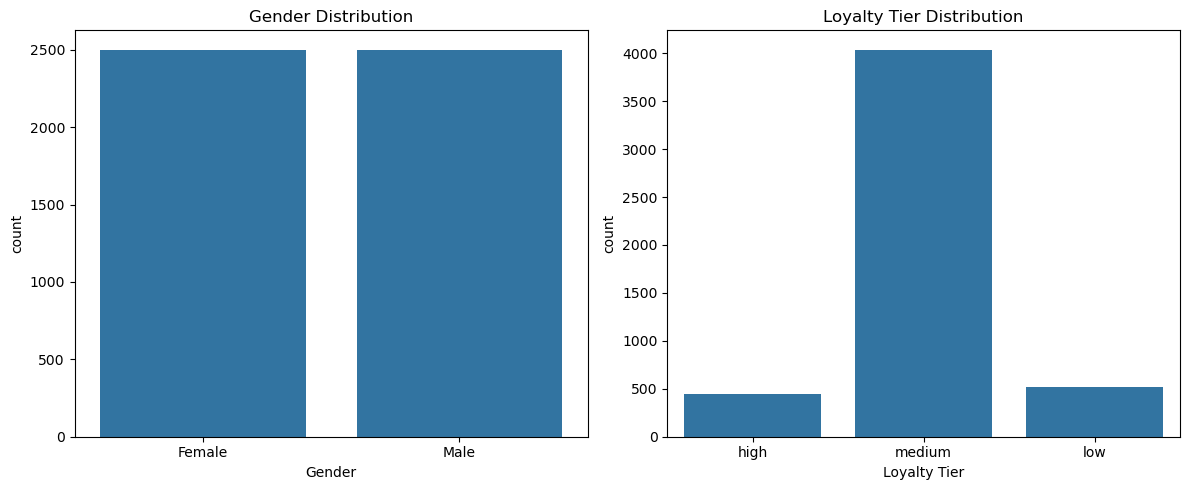

In [27]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df_contact, x='Gender')
plt.title('Gender Distribution')
plt.subplot(1, 2, 2)
sns.countplot(data=df_contact, x='Loyalty Tier', order=['high', 'medium', 'low'])
plt.title('Loyalty Tier Distribution')
plt.tight_layout()

Text(0.5, 1.0, 'Income Distribution')

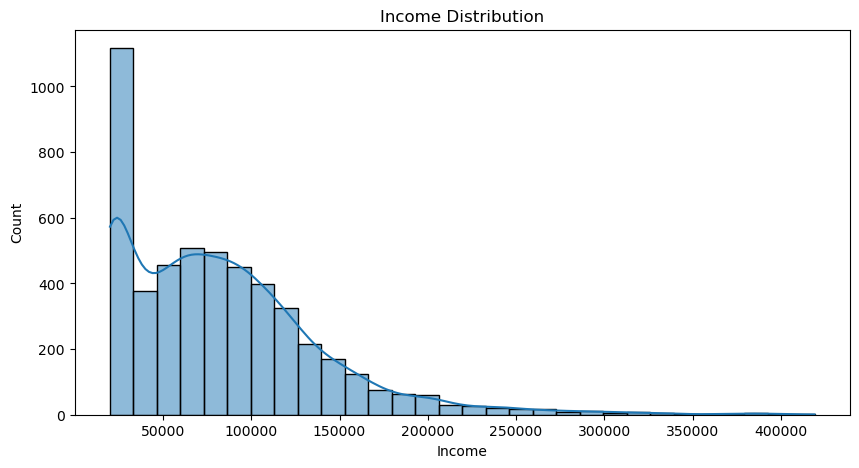

In [34]:
plt.figure(figsize=(10, 5))
sns.histplot(df_contact['Income'], kde=True, bins=30)
plt.title('Income Distribution')


## Purchases

In [ ]:
df_purchase.head(2)

,ContactId,PurchaseId,ProductId,PurchasedOn,TotalPrice,ActivityTypeDisplay,Subject
0,CNTID_1000,OPID_1000,ProdID_1007,1/20/2019,2516,OnlinePurchase,Purchased a product online
1,CNTID_1000,OPID_1001,ProdID_1032,11/4/2018,2597,OnlinePurchase,Purchased a product online


In [70]:
df_purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12369 entries, 0 to 12368
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ContactId            12369 non-null  object
 1   PurchaseId           12369 non-null  object
 2   ProductId            12369 non-null  object
 3   PurchasedOn          12369 non-null  object
 4   TotalPrice           12369 non-null  int64 
 5   ActivityTypeDisplay  12369 non-null  object
 6   Subject              12369 non-null  object
dtypes: int64(1), object(6)
memory usage: 676.6+ KB


In [72]:
df_purchase["PurchasedOn"] = pd.to_datetime (df_purchase["PurchasedOn"])

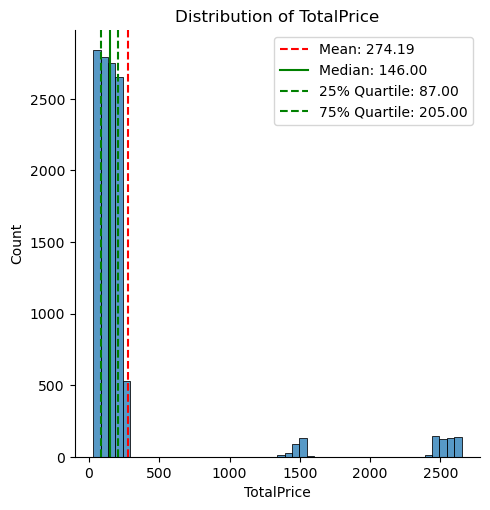

In [68]:
descriptive_stats = df_purchase["TotalPrice"].describe()
mean_value = descriptive_stats["mean"]
median_value = descriptive_stats["50%"]
quartile_25 = descriptive_stats["25%"]
quartile_75 = descriptive_stats["75%"]
# 2. Create the displot
ax = sns.displot(df_purchase["TotalPrice"], bins=50).set(title="Distribution of TotalPrice").axes[0, 0]

# 3. Mark the mean and median on the x-axis
plt.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='g', linestyle='-', label=f'Median: {median_value:.2f}')
plt.axvline(quartile_25, color='g', linestyle='--', label=f'25% Quartile: {quartile_25:.2f}')
plt.axvline(quartile_75, color='g', linestyle='--', label=f'75% Quartile: {quartile_75:.2f}')
plt.legend()

# # 4. Prepare the text for the textbox
textstr = '\n'.join((
    f'Std: {descriptive_stats["std"]:.2f}',
))

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)



C:\Users\mamma\AppData\Local\Temp\ipykernel_25536\430028987.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_purchase.set_index('PurchasedOn')['TotalPrice'].resample('M').sum().plot(figsize=(12, 5))


Text(0.5, 0, 'Month')

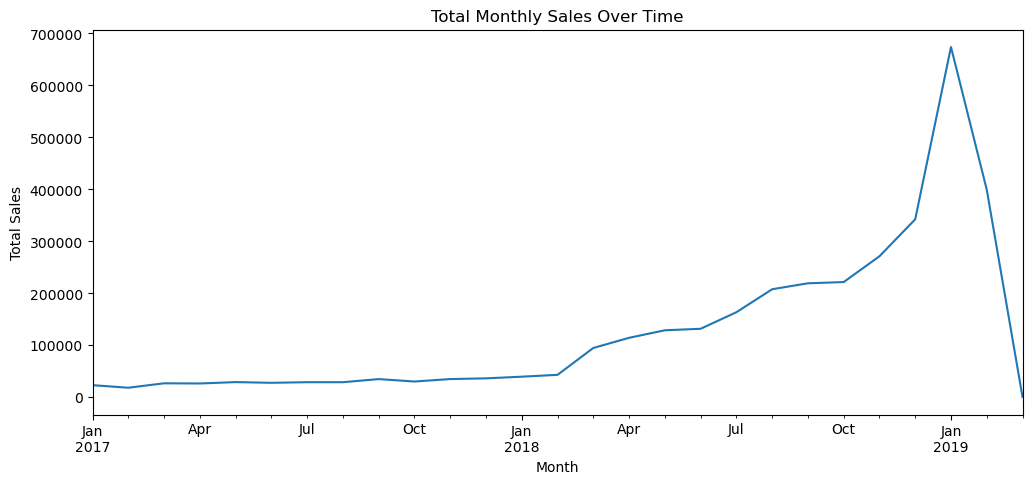

In [75]:
df_purchase.set_index('PurchasedOn')['TotalPrice'].resample('M').sum().plot(figsize=(12, 5))
plt.title('Total Monthly Sales Over Time')
plt.ylabel('Total Sales')
plt.xlabel('Month')

Text(0, 0.5, 'Average TotalPrice')

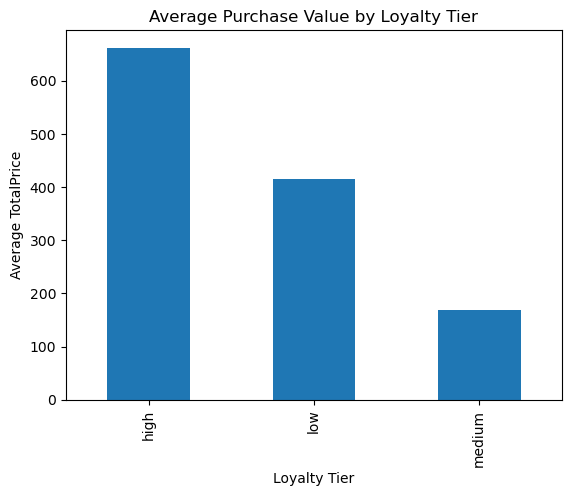

In [91]:
df_merged = pd.merge(df_purchase, df_contact, on='ContactId', how='left')
avg_purchase_by_tier = df_merged.groupby('Loyalty Tier')['TotalPrice'].mean()

avg_purchase_by_tier.plot.bar()
plt.title('Average Purchase Value by Loyalty Tier')
plt.ylabel('Average TotalPrice')

## Preprocess data

In [ ]:
df_clv_data = df_purchase[['ContactId', 'PurchasedOn', 'TotalPrice']].copy()
df_clv_data = df_clv_data.drop_duplicates()

In [93]:
df_clv_data.isna().sum()

ContactId      0
PurchasedOn    0
TotalPrice     0
dtype: int64

### Outlier detection using IQR

IQR is generally a good choice for data that may not be normally distributed. It's robust to extreme values.

In [99]:
Q1 = df_clv_data["TotalPrice"].quantile(0.25)
Q3 = df_clv_data["TotalPrice"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_clv_data_no_outliers_iqr = df_clv_data[
    (df_clv_data["TotalPrice"] >= lower_bound) & (df_clv_data["TotalPrice"] <= upper_bound)
]

print(f"Original DataFrame shape: {df_clv_data.shape}")
print(f"DataFrame shape after IQR outlier removal: {df_clv_data_no_outliers_iqr.shape}")
print(f"% of data kept: {df_clv_data_no_outliers_iqr.shape[0]/df_clv_data.shape[0] * 100:.2f}%")


Original DataFrame shape: (12369, 3)
DataFrame shape after IQR outlier removal: (11555, 3)
% of data kept: 93.42%


### Outlier detection using ZScore

Suitable if data is approximately normally distributed. Be cautious if the data is heavily skewed, as the mean and standard deviation can be influenced by outliers.

In [101]:
mean_price = df_clv_data["TotalPrice"].mean()
std_price = df_clv_data["TotalPrice"].std()

# Define the number of standard deviations to consider as outliers (e.g., 3)
n_std = 3

lower_bound = mean_price - n_std * std_price
upper_bound = mean_price + n_std * std_price

# Filter the DataFrame
df_clv_data_no_outliers_std = df_clv_data[
    (df_clv_data["TotalPrice"] >= lower_bound) & (df_clv_data["TotalPrice"] <= upper_bound)
]

print(f"Original DataFrame shape: {df_clv_data.shape}")
print(f"DataFrame shape after standard deviation outlier removal: {df_clv_data_no_outliers_std.shape}")
print(f"% of data kept: {df_clv_data_no_outliers_std.shape[0]/df_clv_data.shape[0] * 100:.2f}%")


Original DataFrame shape: (12369, 3)
DataFrame shape after standard deviation outlier removal: (11819, 3)
% of data kept: 95.55%


# CLV

For standard CLV models (like BG/NBD and Gamma-Gamma), we primarily need:
ContactId
PurchasedOn
TotalPrice


Create the RFM (Recency, Frequency, Monetary Value, Tenure) Summary Dataframe
This transforms transaction data into the required format:
- frequency: Number of repeat purchases (T > 1)
- recency: Time between first and last purchase (T_last - T_first)
- T: Time since customer's first purchase (Analysis Date - T_first)
- monetary_value: Average value of repeat purchases


Fit the BG/NBD (Beta Geometric/Negative Binomial Distribution) Model
This model predicts the number of future purchases a customer will make.</br>
It assumes:</br>
 a) While active, transactions follow a Poisson process.</br>
 b) Heterogeneity in transaction rates follows a Gamma distribution.</br>
 c) Customers dropout after each transaction with a probability (geometric process).</br>
 d) Heterogeneity in dropout probability follows a Beta distribution.</br>




Gamma-Gamma Model: Checks the assumption of independence between monetary value and frequency. Fits the GammaGammaFitter to model the average transaction value for customers who made repeat purchases.

CLV Calculation: Uses ggf.customer_lifetime_value() which internally uses both the BG/NBD model (for purchase count) and the Gamma-Gamma model (for purchase value) to estimate the total monetary value over a specified future period, considering a discount rate.



## RFM Summary

In [107]:
observation_period_end = df_clv_data['PurchasedOn'].max() + pd.Timedelta(days=1)
df_clv_data['PurchasedOn'].max(), observation_period_end

(Timestamp('2019-03-06 00:00:00'), Timestamp('2019-03-07 00:00:00'))

In [ ]:
# to convert the transaction log into the RFM (Recency, Frequency, Monetary Value, Tenure) format required by the models.
rfm_summary = lifetimes.utils.summary_data_from_transaction_data(
    df_clv_data,
    customer_id_col='ContactId',
    datetime_col='PurchasedOn',
    monetary_value_col='TotalPrice',
    observation_period_end=observation_period_end,
    freq='D' # Frequency unit (Days)
)

In [144]:
format_dict = {
    'frequency': '{:.0f}',
    'recency': '{:.0f}',
    'T': '{:.0f}',
    'monetary_value': '{:.2f}',
    'predicted_purchases': '{:.2f}',
    'predicted_avg_profit': '{:.2f}',
    'clv': '{:.2f}',
    'clv_1yr': '{:.2f}'
}

In [145]:
rfm_summary.head().style.format(format_dict)

,frequency,recency,T,monetary_value,predicted_purchases,predicted_avg_profit,clv,clv_1yr
ContactId,,,,,,,,
98e79d76-a45a-e911-a970-000d3a39c2c9,0,0,576,0.00,0.22,253.36,224.34,5764.40
CNTID_1000,3,319,365,2567.33,0.59,2546.65,6076.37,138575.33
CNTID_1003,0,0,575,0.00,0.22,253.36,224.55,5769.36
CNTID_1004,0,0,228,0.00,0.32,253.36,334.55,8220.31
CNTID_1006,1,80,133,245.00,0.52,245.22,516.25,11895.74


In [121]:
# customers who only purchased once (frequency=0)
sum(rfm_summary['frequency'] == 0)

853

## BG/NBD Model

Fits the BetaGeoFitter to the RFM data to model purchase frequency and predict future transactions. Includes optional diagnostic plots.

In [ ]:
# Fits the BetaGeoFitter to the RFM data to model purchase frequency and predict future transactions.
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.0) # Penalizer avoids overfitting
bgf.fit(rfm_summary['frequency'], rfm_summary['recency'], rfm_summary['T'])

<lifetimes.BetaGeoFitter: fitted with 4124 subjects, a: 308.54, alpha: 476.48, b: 53840.01, r: 2.54>

###  diagnostic plots

Text(0.5, 1.0, 'Frequency/Recency Matrix (Expected Purchases)')

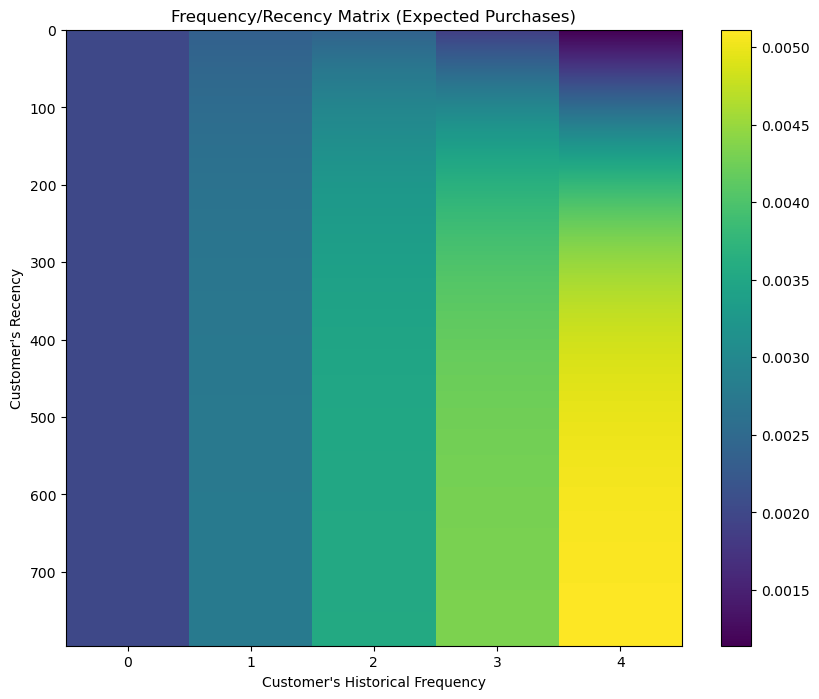

In [125]:
plt.figure(figsize=(10, 8))
plot_frequency_recency_matrix(bgf)
plt.title('Frequency/Recency Matrix (Expected Purchases)')

Text(0.5, 1.0, 'Probability Customer is Alive')

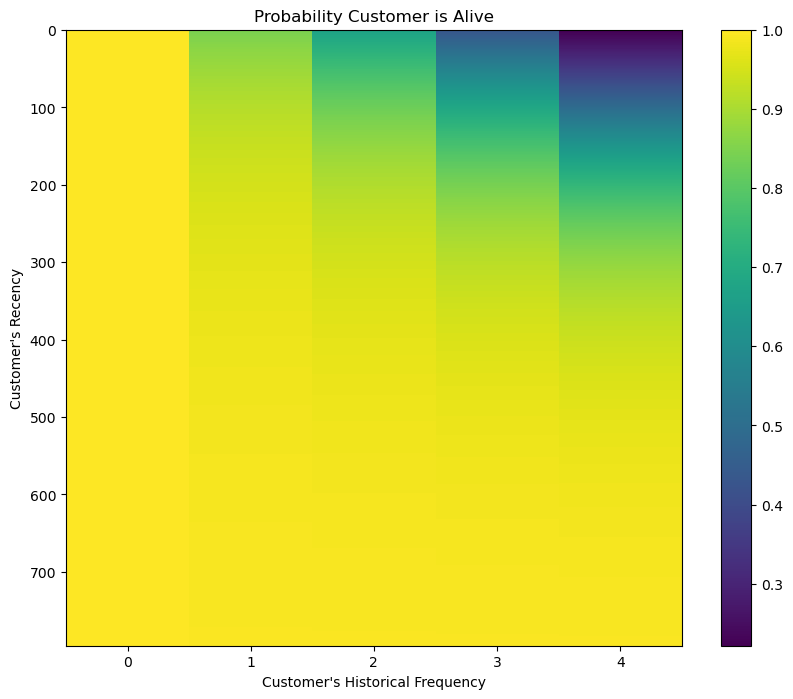

In [127]:
plt.figure(figsize=(10, 8))
lifetimes.plotting.plot_probability_alive_matrix(bgf)
plt.title('Probability Customer is Alive')

## Predict Future Purchases

Predict expected number of purchases in the next 't' days (e.g., 90 days)

In [ ]:
t = 90 # Prediction period in days
rfm_summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t,
    rfm_summary['frequency'],
    rfm_summary['recency'],
    rfm_summary['T']
)
print(f"RFM Summary with Predicted Purchases (next {t} days):")
rfm_summary.head()


RFM Summary with Predicted Purchases (next 90 days):


,frequency,recency,T,monetary_value,predicted_purchases
ContactId,,,,,
98e79d76-a45a-e911-a970-000d3a39c2c9,0.0,0.0,576.0,0.000000,0.216888
CNTID_1000,3.0,319.0,365.0,2567.333333,0.586604
CNTID_1003,0.0,0.0,575.0,0.000000,0.217094
CNTID_1004,0.0,0.0,228.0,0.000000,0.323890
CNTID_1006,1.0,80.0,133.0,245.000000,0.517437


## Fit the Gamma-Gamma Model

In [ ]:
# Checking Gamma-Gamma Assumption (Correlation between frequency and monetary_value)
ggf_data = rfm_summary[rfm_summary['frequency'] > 0]
ggf_data[['frequency', 'monetary_value']].corr()


,frequency,monetary_value
frequency,1.000000,0.085075
monetary_value,0.085075,1.000000


correlation is low (e.g., < 0.2), the assumption holds reasonably well.

In [131]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(ggf_data['frequency'], ggf_data['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 3271 subjects, p: 43.58, q: 2.18, v: 6.86>

## Calculate Customer Lifetime Value (CLV)

Predict the conditional expected average profit (monetary value) </br>
Note: This is calculated only for customers with frequency > 0

In [132]:
rfm_summary['predicted_avg_profit'] = ggf.conditional_expected_average_profit(
    rfm_summary['frequency'],
    rfm_summary['monetary_value']
)

## Calculate CLV for a specific period


This combines the BG/NBD (purchase frequency) and Gamma-Gamma (monetary value) models. </br>
Discount rate (e.g., 10% per year -> 0.1/12 per month -> ~0.0083 per month)</br>
Let's use days, so daily rate = (1+0.10)**(1/365) - 1 ~= 0.00026</br>

In [133]:
discount_rate_daily = 0.1 / 365
prediction_period_clv = 365 # Days (e.g., 1 year)

rfm_summary['clv'] = ggf.customer_lifetime_value(
    bgf, # The model to use to predict the number of future transactions
    rfm_summary['frequency'],
    rfm_summary['recency'],
    rfm_summary['T'],
    rfm_summary['monetary_value'],
    time=prediction_period_clv / 30, # time in months (adjust 'freq' if needed) -> Let's adjust to days
    freq='D', # Frequency unit matches summary_data_from_transaction_data
    discount_rate=discount_rate_daily * 30 # Approximate monthly discount rate if freq='D' is tricky, or adjust time param
)

## CLV using daily frequency and discount rate

The `customer_lifetime_value` method's `time` parameter is often interpreted relative to the `freq` unit.</br>
Let's be explicit with daily prediction

In [134]:
rfm_summary['clv_1yr'] = ggf.customer_lifetime_value(
    bgf,
    rfm_summary['frequency'],
    rfm_summary['recency'],
    rfm_summary['T'],
    rfm_summary['monetary_value'],
    time=prediction_period_clv, # Number of days to predict
    freq='D',                  # Unit of time
    discount_rate=discount_rate_daily
)

In [ ]:
rfm_summary.head(5).style.format(format_dict)

,frequency,recency,T,monetary_value,predicted_purchases,predicted_avg_profit,clv,clv_1yr
ContactId,,,,,,,,
98e79d76-a45a-e911-a970-000d3a39c2c9,0,0,576,0.00,0.22,253.36,224.34,5764.40
CNTID_1000,3,319,365,2567.33,0.59,2546.65,6076.37,138575.33
CNTID_1003,0,0,575,0.00,0.22,253.36,224.55,5769.36
CNTID_1004,0,0,228,0.00,0.32,253.36,334.55,8220.31
CNTID_1006,1,80,133,245.00,0.52,245.22,516.25,11895.74


Text(0, 0.5, 'Number of Customers')

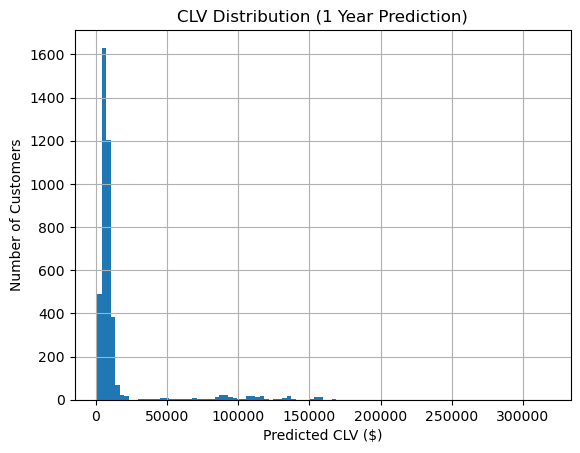

In [140]:
rfm_summary['clv_1yr'].hist(bins=100)
plt.title('CLV Distribution (1 Year Prediction)')
plt.xlabel('Predicted CLV ($)')
plt.ylabel('Number of Customers')

In [ ]:
print("Top 10 Customers by Predicted CLV (1 Year):")
rfm_summary.sort_values(by='clv_1yr', ascending=False).head(10).style.format(format_dict)

Top 10 Customers by Predicted CLV (1 Year):


,frequency,recency,T,monetary_value,predicted_purchases,predicted_avg_profit,clv,clv_1yr
ContactId,,,,,,,,
CNTID_1599,1,10,40,5895.00,0.61,5746.34,14266.85,317804.00
CNTID_4817,1,339,368,7622.00,0.37,7427.84,11327.39,275496.37
CNTID_5222,1,1,30,4544.00,0.62,4430.94,11216.35,248775.64
CNTID_4889,1,10,39,4440.00,0.61,4329.68,10770.78,239824.68
CNTID_1560,2,6,35,2954.50,0.79,2918.44,9359.99,197911.98
CNTID_5523,3,310,367,3398.67,0.58,3370.55,8018.39,182951.44
CNTID_2010,3,360,389,3421.67,0.57,3393.34,7880.99,180737.80
CNTID_3830,3,357,386,3317.67,0.57,3290.27,7667.94,175731.80
CNTID_1506,2,341,373,3818.00,0.48,3770.41,7319.78,172589.83


# Post-CLV Analysis & Segmentation

In [ ]:
df_customer_clv = df_contact.merge(rfm_summary.reset_index(), on='ContactId', how='left')

# Fill NA CLV for customers with no purchases or only one purchase (CLV would be near 0)
df_customer_clv['clv_1yr'].fillna(0, inplace=True)

## Create CLV Segments 

divide customers into segments (e.g., Low, Medium, High) based on their CLV scores quantiles

In [151]:
# 
df_customer_clv['clv_segment'] = pd.qcut(df_customer_clv['clv_1yr'], q=4, labels=['Low', 'Medium', 'High', 'Very High'], duplicates='drop')


Average Income by CLV Segment:


<Axes: xlabel='clv_segment'>

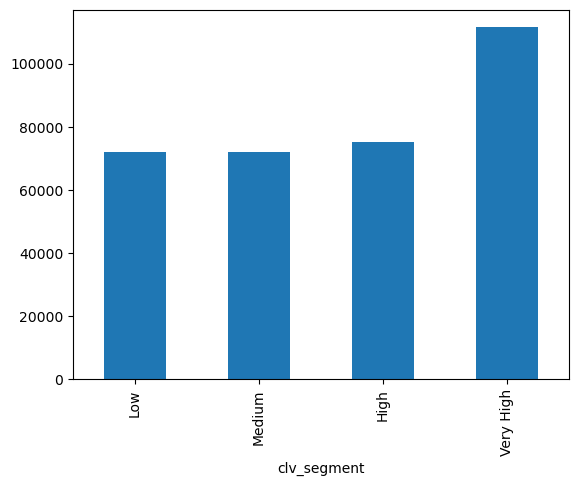

In [154]:
print("Average Income by CLV Segment:")
df_customer_clv.groupby('clv_segment')['Income'].mean().plot.bar()

In [156]:
print("Loyalty Tier Distribution within CLV Segments:")
pd.crosstab(df_customer_clv['clv_segment'], df_customer_clv['Loyalty Tier'])


Loyalty Tier Distribution within CLV Segments:


Loyalty Tier,high,low,medium
clv_segment,,,
Low,0,108,1142
Medium,15,108,1127
High,106,114,1030
Very High,322,190,738


Text(0.5, 1.0, 'Income Distribution by CLV Segment')

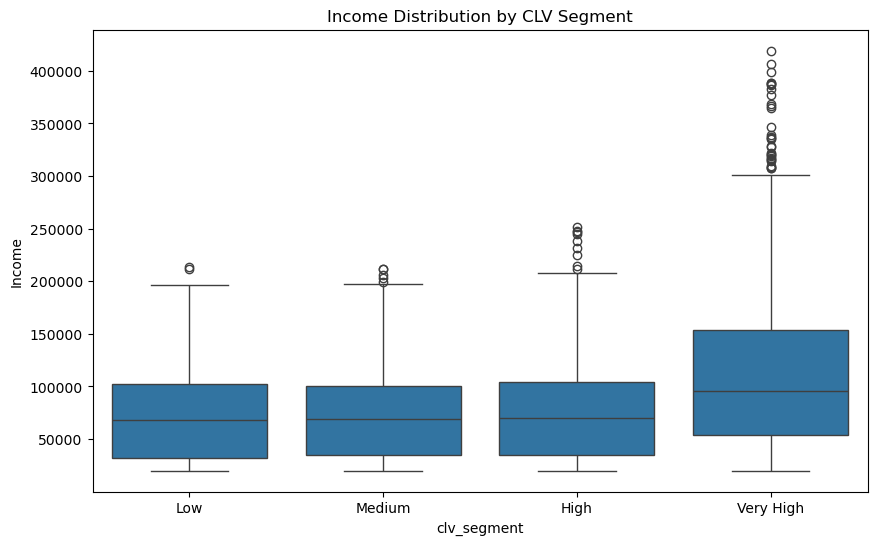

In [157]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_customer_clv, x='clv_segment', y='Income', order=['Low', 'Medium', 'High', 'Very High'])
plt.title('Income Distribution by CLV Segment')